<center>
<img src="data/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2

Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Тема 5. Композиции алгоритмов, случайный лес
## <center>Практика. Деревья решений и случайный лес в соревновании Kaggle Inclass по кредитному скорингу

Тут веб-формы для ответов нет, ориентируйтесь на рейтинг [соревнования](https://inclass.kaggle.com/c/beeline-credit-scoring-competition-2), [ссылка](https://www.kaggle.com/t/115237dd8c5e4092a219a0c12bf66fc6) для участия.

Решается задача кредитного скоринга. 

Признаки клиентов банка:
- Age - возраст (вещественный)
- Income - месячный доход (вещественный)
- BalanceToCreditLimit - отношение баланса на кредитной карте к лимиту по кредиту (вещественный)
- DIR - Debt-to-income Ratio (вещественный)
- NumLoans - число заемов и кредитных линий
- NumRealEstateLoans - число ипотек и заемов, связанных с недвижимостью (натуральное число)
- NumDependents - число членов семьи, которых содержит клиент, исключая самого клиента (натуральное число)
- Num30-59Delinquencies - число просрочек выплат по кредиту от 30 до 59 дней (натуральное число)
- Num60-89Delinquencies - число просрочек выплат по кредиту от 60 до 89 дней (натуральное число)
- Delinquent90 - были ли просрочки выплат по кредиту более 90 дней (бинарный) - имеется только в обучающей выборке

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

**Загружаем данные.**

In [2]:
train_df = pd.read_csv('data/credit_scoring_train.csv', index_col='client_id')
test_df = pd.read_csv('data/credit_scoring_test.csv', index_col='client_id')

In [3]:
y = train_df['Delinquent90']
train_df.drop('Delinquent90', axis=1, inplace=True)

In [4]:
train_df.head()

,DIR,Age,NumLoans,NumRealEstateLoans,NumDependents,Num30-59Delinquencies,Num60-89Delinquencies,Income,BalanceToCreditLimit
client_id,,,,,,,,,
0,0.496289,49.1,13,0,0.0,2,0,5298.360639,0.387028
1,0.433567,48.0,9,2,2.0,1,0,6008.056256,0.234679
2,2206.731199,55.5,21,1,NaN,1,0,NaN,0.348227
3,886.132793,55.3,3,0,0.0,0,0,NaN,0.971930
4,0.000000,52.3,1,0,0.0,0,0,2504.613105,1.004350


**Посмотрим на число пропусков в каждом признаке.**

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75000 entries, 0 to 74999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   DIR                    75000 non-null  float64
 1   Age                    75000 non-null  float64
 2   NumLoans               75000 non-null  int64  
 3   NumRealEstateLoans     75000 non-null  int64  
 4   NumDependents          73084 non-null  float64
 5   Num30-59Delinquencies  75000 non-null  int64  
 6   Num60-89Delinquencies  75000 non-null  int64  
 7   Income                 60153 non-null  float64
 8   BalanceToCreditLimit   75000 non-null  float64
dtypes: float64(5), int64(4)
memory usage: 5.7 MB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75000 entries, 75000 to 149999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   DIR                    75000 non-null  float64
 1   Age                    75000 non-null  float64
 2   NumLoans               75000 non-null  int64  
 3   NumRealEstateLoans     75000 non-null  int64  
 4   NumDependents          72992 non-null  float64
 5   Num30-59Delinquencies  75000 non-null  int64  
 6   Num60-89Delinquencies  75000 non-null  int64  
 7   Income                 60116 non-null  float64
 8   BalanceToCreditLimit   75000 non-null  float64
dtypes: float64(5), int64(4)
memory usage: 5.7 MB


**Заменим пропуски медианными значениями.**

In [7]:
train_df['NumDependents'].fillna(train_df['NumDependents'].median(), inplace=True)
train_df['Income'].fillna(train_df['Income'].median(), inplace=True)
test_df['NumDependents'].fillna(test_df['NumDependents'].median(), inplace=True)
test_df['Income'].fillna(test_df['Income'].median(), inplace=True)

### Дерево решений без настройки параметров

**Обучите дерево решений максимальной глубины 3, используйте параметр random_state=17 для воспроизводимости результатов.**

In [8]:
first_tree = DecisionTreeClassifier(max_depth=3, random_state=17)
first_tree.fit(train_df, y)

DecisionTreeClassifier(max_depth=3, random_state=17)

**Сделайте прогноз для тестовой выборки.**

In [9]:
first_tree_pred = first_tree.predict(test_df)
first_tree_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

**Запишем прогноз в файл.**

In [10]:
def write_to_submission_file(predicted_labels, out_file,
                             target='Delinquent90', index_label="client_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(75000, 
                                                  predicted_labels.shape[0] + 75000),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [11]:
write_to_submission_file(first_tree_pred, 'credit_scoring_first_tree.csv')

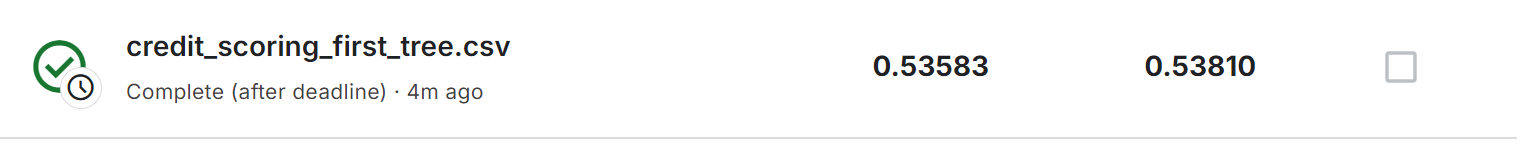

**Если предсказывать вероятности дефолта для клиентов тестовой выборки, результат будет намного лучше.**

In [12]:
first_tree_pred_probs = first_tree.predict_proba(test_df)[:, 1]

In [13]:
first_tree_pred_probs

array([0.02090472, 0.28203575, 0.02090472, ..., 0.09396285, 0.02090472,
       0.09396285])

In [14]:
write_to_submission_file(first_tree_pred_probs, 'credit_scoring_first_tree_probs.csv')

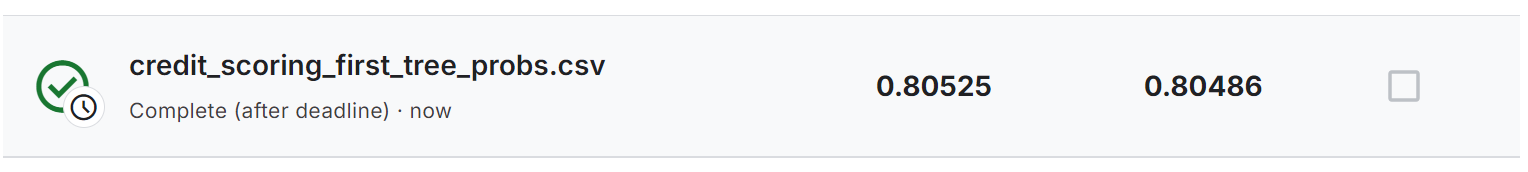

## Дерево решений с настройкой параметров с помощью GridSearch

**Настройте параметры дерева с помощью `GridSearhCV`, посмотрите на лучшую комбинацию параметров и среднее качество на 5-кратной кросс-валидации. Используйте параметр `random_state=17` (для воспроизводимости результатов), не забывайте про распараллеливание (`n_jobs=-1`).**

In [15]:
tree_params = {'max_depth': list(range(3, 8)), 
               'min_samples_leaf': list(range(5, 13))}

locally_best_tree = GridSearchCV(DecisionTreeClassifier(random_state=17), tree_params, cv=5, scoring="roc_auc", n_jobs=-1, verbose=1)
locally_best_tree.fit(train_df, y)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=17), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7],
                         'min_samples_leaf': [5, 6, 7, 8, 9, 10, 11, 12]},
             scoring='roc_auc', verbose=1)

In [16]:
locally_best_tree.best_params_, round(locally_best_tree.best_score_, 3)

({'max_depth': 6, 'min_samples_leaf': 12}, 0.829)

**Сделайте прогноз для тестовой выборки и пошлите решение на Kaggle.**

In [17]:
tuned_tree_pred_probs = locally_best_tree.best_estimator_.predict_proba(test_df)[:, 1]

In [18]:
write_to_submission_file(tuned_tree_pred_probs, "credit_scoring_tuned_tree_probs.csv")

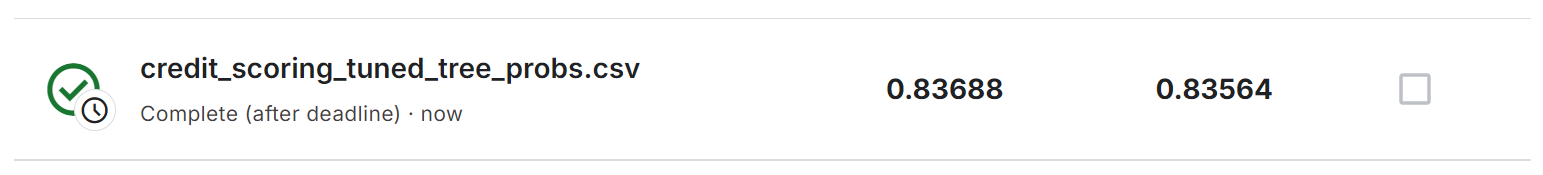

### Случайный лес без настройки параметров

**Обучите случайный лес из деревьев неограниченной глубины, используйте параметр `random_state=17` для воспроизводимости результатов.**

In [19]:
first_forest = RandomForestClassifier(random_state=17)
first_forest.fit(train_df, y)

RandomForestClassifier(random_state=17)

In [20]:
first_forest_pred = first_forest.predict_proba(test_df)[:, 1]

**Сделайте прогноз для тестовой выборки и пошлите решение на Kaggle.**

In [21]:
write_to_submission_file(first_forest_pred, "credit_scoring_first_rf.csv")

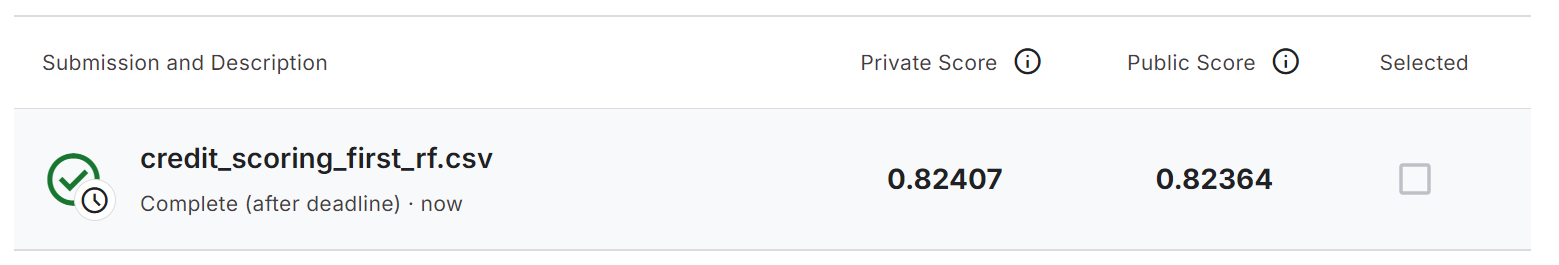

### Случайный лес c настройкой параметров

**Настройте параметр `max_features` леса с помощью `GridSearhCV`, посмотрите на лучшую комбинацию параметров и среднее качество на 5-кратной кросс-валидации. Используйте параметр random_state=17 (для воспроизводимости результатов), не забывайте про распараллеливание (n_jobs=-1).**

In [22]:
%%time
forest_params = {'max_features': np.linspace(.3, 1, 7)}

locally_best_forest = GridSearchCV(RandomForestClassifier(random_state=17), forest_params, scoring="roc_auc", n_jobs=-1, verbose=1)
locally_best_forest.fit(train_df, y)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
CPU times: total: 33.6 s
Wall time: 8min 24s


GridSearchCV(estimator=RandomForestClassifier(random_state=17), n_jobs=-1,
             param_grid={'max_features': array([0.3       , 0.41666667, 0.53333333, 0.65      , 0.76666667,
       0.88333333, 1.        ])},
             scoring='roc_auc', verbose=1)

In [23]:
locally_best_forest.best_params_, round(locally_best_forest.best_score_, 3)

({'max_features': 0.3}, 0.824)

In [24]:
tuned_forest_pred = locally_best_forest.predict_proba(test_df)[:, 1]

In [25]:
write_to_submission_file(tuned_forest_pred, "credit_scoring_tuned_rf.csv")

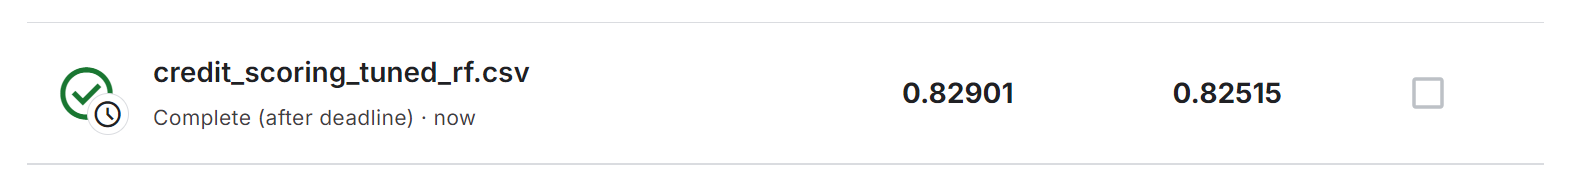

**Посмотрите, как настроенный случайный лес оценивает важность признаков по их влиянию на целевой. Представьте результаты в наглядном виде с помощью `DataFrame`.**

In [26]:
pd.DataFrame(locally_best_forest.best_estimator_.feature_importances_, index=train_df.columns, columns=["importance"]).sort_values(by="importance")

,importance
NumRealEstateLoans,0.032962
NumDependents,0.038709
Num30-59Delinquencies,0.063074
Num60-89Delinquencies,0.065174
NumLoans,0.093227
Income,0.150816
Age,0.160560
DIR,0.170093
BalanceToCreditLimit,0.225384


**Обычно увеличение количества деревьев только улучшает результат. Так что напоследок обучите случайный лес из 300 деревьев с найденными лучшими параметрами. Это может занять несколько минут.**

In [27]:
%%time
final_forest = RandomForestClassifier(n_estimators=300, max_features=0.3, random_state=17)
final_forest.fit(train_df, y)
final_forest_pred = final_forest.predict_proba(test_df)[:, 1]
write_to_submission_file(final_forest_pred, 'credit_scoring_final_forest.csv')

CPU times: total: 1min 38s
Wall time: 1min 41s


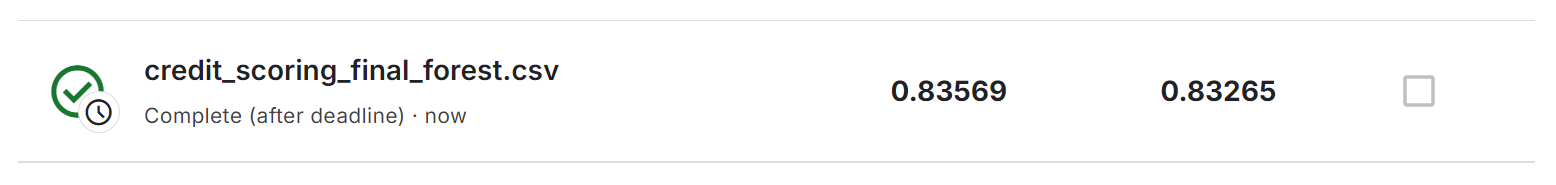

**Сделайте посылку на Kaggle.**